<a href="https://colab.research.google.com/github/ElliotSiegel/Data201/blob/main/Data201_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of US County's net per capita and Covids mortality rate and how well of an indicator is ADI for predicting Covids mortality rate in a county.

Does a US county's net per capita earnings impact how many Covid deaths occur? How well of an indicator is ADI (Average Deprivation Index) for a communities Covid Impact?

* Hypothesis 1: As ADI increases, the Covid Mortality Rate in that community will increase. 
* Hypothesis 2: As net per capita increases, the Covid Mortality Rate in that community will decrease.

The data obtained was from Google public data hub via Big query. The driving query pulls in from three data repositories; Johns Hopkins COVID time-series, US County FIPs Census key, and the Beuro of Economic Analysis.

# Data Description:


# Data Sources
## **Datasets**
1. Johns Hopkins Covid Dataset: Covid data in time series by county
2. Area Deprivation Index (ADI)
3. Beueo of Economic Analysis 

Total rows: 3143

Total features: 8

### JHU COVID DATASET ## 

This is the data repository for the 2019 Novel Coronavirus Visual Dashboard  operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE). The data include the location and number of confirmed COVID-19 cases, deaths, and recoveries for all affected countries, aggregated at the appropriate province/state. It was developed to enable researchers, public health authorities and the general public to track the outbreak. Additional information is available in the blog post, Mapping 2019-nCoV , and included data sources are listed here . -- Taken from google big querys dataset 
description 

### GDP and Income by County - Bureau of Economic Analysis

"This public dataset was created by the Bureau of Economic Analysis (BEA). It provides a county-level view of income, wages, proprietors' income, dividends, interest, rents, and government benefits, including several federal and state-level subsidies.

Per capita income is used to gauge the average financial health and associated social needs of an area.

economic indicators measured by the Department of Commerce or reported to other public agencies <a href="https://apps.bea.gov/regional/definitions/"> Economic accounts and definitions</a>
" -- Taken from google big querys dataset 
description 

### Area Deprivation Index (ADI)

"The Area Deprivation Index (ADI) can show where areas of deprivation and affluence exist within a community. The ADI is calculated with 17 indicators from the American Community Survey (ACS) having been well-studied in the peer-reviewed literature since 2003, and used for 20 years by the Health Resources and Services Administration (HRSA). High levels of deprivation have been linked to health outcomes such as 30-day hospital readmission rates, cardiovascular disease deaths, cervical cancer incidence, cancer deaths, and all-cause mortality. The 17 indicators from the ADI encompass income, education, employment, and housing conditions at the Census Block Group level."-- Taken from google big querys dataset 
description 

## Details
The Data consists of around 3,200 rows - one row per US county - and 8 columns.

#### state_fips_code
State Level FIPS codes defined by the US Census

#### state
* US State

#### fips
* FIPS codes defined by the US Census

#### area_land_meters
* Area in square meters for that areas FIPS Entry

#### total_deaths
* Total COVID deaths up to 12-31-20 grouped by county

#### total_recovered
* Total COVID recovery up to 12-31-20 grouped by county

#### population
* Total US population as calculated in the 5-year population estimate - as of March 2019 (note that this is not the most up to date population count)

#### Percapita_net_earnings
* Net earnings by place of residence of a given area divided by the resident population of the area. See "net earnings by place of residence."

### ADI
* ADI: An index of socioeconomic status for communities calculated in 2020 via 17 indicators from the American Community Survey (ACS)
* A low Average Deprivation index indicates that the community has lower deprivation & vice versa.

### Cause-specific mortality rate

*Cause-specific death rate Number of deaths assigned to a specific cause during a given time interval - in the case of this project were looking at Covid.
*(deaths by specific cause/total population of area) * 100,000



In [ ]:
#NOTE THIS IS INTENDED TO BE RUN IN GOOGLE COLLAB- can be adapted to be run locally, just configure the intial querys to connect to GoogleBigQuery DB over the local network. And adjust the inital query functions



---


Load the relavent EDA python packages

In [ ]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import math as pymath
import matplotlib.pyplot as plt
import statistics as pystat
from scipy import stats as scstats
from google.colab import auth
from sklearn.utils import resample  
from sklearn.linear_model import LinearRegression
from collections import OrderedDict
from scipy.stats import zscore

Authenticate between google and this collab sheet. 

In [ ]:
auth.authenticate_user()
print('Authenticated')

Authenticated


Set the style of the datatabels to be searchable & sortable to aid in the EDA process

In [ ]:
%load_ext google.colab.data_table

Query google BigQuery for JHU Covid timeseries data linked by county FIPS code to ADI, Georgraphic and economic infromation.

> Note: you will need to change bens-website-236514 to you google cloud project name.



In [ ]:
%%bigquery --project bens-website-236514 covid_df

SELECT  
usc.state_fips_code, 
jhu.province_state state,
usc.county_fips_code as fips, 
area_land_meters, 
jhu.deaths total_deaths, 
#jhu.recovered total_recovered, 
bea.population population, 
bea.Percapita_net_earnings,
Round(adi.adip) as ADI
FROM `bigquery-public-data.geo_us_boundaries.counties` usc
Left join (

select 
date,
fips,
deaths,
recovered,
province_state from `bigquery-public-data.covid19_jhu_csse.summary` as jhu
Where jhu.date = '2020-12-31'
and admin2 != 'Unassigned'
and fips is not null 

) as jhu on jhu.fips = usc.county_fips_code
left join (

SELECT year, GeoFIPS fips, population, Percapita_net_earnings FROM `bigquery-public-data.sdoh_bea_cainc30.fips`
where year = '2018-01-01'  -- latest year estimates available.

) bea on bea.fips = usc.county_fips_code
left JOIN (

Select Distinct(county_name), county_fips_code, avg(area_deprivation_index_percent) adip , 
     year from bigquery-public-data.broadstreet_adi.area_deprivation_index_by_census_block_group group by  county_name, year, county_fips_code

) as adi on (jhu.fips = adi.county_fips_code and EXTRACT(Year FROM jhu.date) = adi.year)

Where usc.state_fips_code not in ('60','66','69','72','78')

# American Samoa	AS	60
# Guam	GU	66
# Northern Mariana Islands	MP	69
# Puerto Rico	PR	72
# Virgin Islands	VI	78

In [ ]:
#dfCOVID
def rowcountcheck(rowcount):
  total_us_counties = 3143  # total US counties excluding terroritory county equivalents. Tajeb from the US county wiki 'In all, the 50 states consist of 3,142 counties and equivalents. Adding the District of Columbia gives 3,143.'
  if total_us_counties != rowcount:
      print("A diffrent number of rows were loaded from the number of US counties as of 2020. " + str(total_us_counties) + " total counties expected but " + str(rowcount) + " rows loaded")
    # print(str(total_us_counties) + " total counties does not match the " + str(dfCOVID.shape[0]) + " rows loaded" )
  else: 
      print(str(total_us_counties) + " total counties matches the " + str(rowcount) + " rows loaded")


rowcountcheck(covid_df.shape[0])


A diffrent number of rows were loaded from the number of US counties as of 2020. 3143 total counties expected but 3142 rows loaded


### Looking at the [ us county wiki ](https://en.wikipedia.org/wiki/County_(United_States)) we should be seeing 3143 total counties. Lets explore why theres a mismatch. 


In [ ]:
%%bigquery --project bens-website-236514 county_df

Select usc.county_fips_code fips , state_fips_code, county_name FROM `bigquery-public-data.geo_us_boundaries.counties` usc Where usc.state_fips_code not in ('60','66','69','72','78')

### Grabbing the total list of US County FIPS codes to compare to our filtered list

In [ ]:
#Left joining in order to see which rows exist in the full list but not 
#dfCountyComp =  pd.merge(dfCOUNTY,dfCOVID, on='fips',how='left')

dfCountyComp = county_df.merge(covid_df.drop_duplicates(), on=['fips','fips'], how='left', indicator=True)
dfCountyComp = dfCountyComp[dfCountyComp['_merge'] == 'left_only']

print( str(dfCountyComp.shape[0]) + " rows on the full county list that are not on the JHU Covid list")  

0 rows on the full county list that are not on the JHU Covid list


### Now lets check for nulls

#### Describe and do a quick check for inconsistencies in counts. 



In [ ]:
"Notice that the count of area_land_meters is greater than total_deaths, recovered and population. This means there are null entries that need to be explored"

covid_df.isna().sum()


state_fips_code            0
state                     26
fips                       0
area_land_meters           0
total_deaths              26
population                53
Percapita_net_earnings    53
ADI                       26
dtype: int64

In [ ]:
"lets grab the null entries and see if theres any pattern"

is_NaN = covid_df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = covid_df[row_has_NaN]

print(rows_with_NaN.shape)
rows_with_NaN.info()

print('looks like there are 78 rows with null entries. Time to dive into the specifics')


(78, 8)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 69 to 2952
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state_fips_code         78 non-null     object 
 1   state                   52 non-null     object 
 2   fips                    78 non-null     object 
 3   area_land_meters        78 non-null     int64  
 4   total_deaths            52 non-null     float64
 5   population              25 non-null     float64
 6   Percapita_net_earnings  25 non-null     float64
 7   ADI                     52 non-null     float64
dtypes: float64(4), int64(1), object(3)
memory usage: 5.5+ KB
looks like there are 78 rows with null entries. Time to dive into the specifics


In [ ]:
print("Total % of rows lost by dropping those with NaN: " + str((rows_with_NaN.shape[0]/covid_df.shape[0])*100))
covid_df = covid_df.dropna()


Total % of rows lost by dropping those with NaN: 2.4824952259707196


In [ ]:
"lets now do a quick dive and see if any additional rows should be removed becouse of suspect data enty. One thing to look for would be where there are both 0 recovered and 0 deaths for all of 2020. This data should be thrown out"
noCounts = covid_df[(covid_df['total_deaths'] == 0) ]

print(noCounts.count())

#Dropping 0 death counties
covid_df = covid_df.drop(covid_df[(covid_df['total_deaths'] == 0.0)].index)


state_fips_code           78
state                     78
fips                      78
area_land_meters          78
total_deaths              78
population                78
Percapita_net_earnings    78
ADI                       78
dtype: int64


In [ ]:
print("Final row count is " + str(covid_df.shape[0]))

Final row count is 2986


In [ ]:
### Calculate Population density and deaths per 1,000 by county 
covid_df.describe

covid_df['pop_density'] = covid_df['population']/covid_df['area_land_meters']
covid_df['death_rate'] = ((covid_df['total_deaths']/covid_df['population'])*100000)


In [ ]:
#covid_df = county_df
covid_df.to_csv('out.csv')

In [ ]:
covid_df

,state_fips_code,state,fips,area_land_meters,total_deaths,population,Percapita_net_earnings,ADI,pop_density,death_rate
0,01,Alabama,01131,2301075085,19.0,10627.0,13212.0,76.0,0.000005,178.789875
1,01,Alabama,01075,1566544637,15.0,13844.0,17056.0,74.0,0.000009,108.350188
2,01,Alabama,01039,2669134207,40.0,36986.0,18342.0,70.0,0.000014,108.149029
3,01,Alabama,01019,1433623319,22.0,26032.0,18967.0,64.0,0.000018,84.511371
4,01,Alabama,01027,1564251834,34.0,13275.0,17801.0,74.0,0.000008,256.120527
...,...,...,...,...,...,...,...,...,...,...
3137,56,Wyoming,56039,10351784298,4.0,23081.0,59809.0,28.0,0.000002,17.330272
3138,56,Wyoming,56001,11070455501,9.0,38601.0,24650.0,52.0,0.000003,23.315458
3139,56,Wyoming,56013,23785388828,64.0,39531.0,23942.0,58.0,0.000002,161.898257
3140,56,Wyoming,56037,27005754251,16.0,43051.0,39216.0,47.0,0.000002,37.165223


In [ ]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2986 entries, 0 to 3141
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state_fips_code         2986 non-null   object 
 1   state                   2986 non-null   object 
 2   fips                    2986 non-null   object 
 3   area_land_meters        2986 non-null   int64  
 4   total_deaths            2986 non-null   float64
 5   population              2986 non-null   float64
 6   Percapita_net_earnings  2986 non-null   float64
 7   ADI                     2986 non-null   float64
 8   pop_density             2986 non-null   float64
 9   death_rate              2986 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 256.6+ KB


In [ ]:
covid_df.describe()

,area_land_meters,total_deaths,population,Percapita_net_earnings,ADI,pop_density,death_rate
count,2.986000e+03,2986.000000,2.986000e+03,2986.000000,2986.000000,2.986000e+03,2986.000000
mean,2.833320e+09,113.757200,1.079222e+05,25145.324180,59.410248,1.014108e-04,121.113834
std,9.289594e+09,431.198641,3.408493e+05,9145.900352,13.877647,7.067963e-04,85.672579
min,3.867938e+07,1.000000,4.420000e+02,6495.000000,12.000000,1.412852e-08,1.386328
25%,1.124218e+09,11.000000,1.185375e+04,19187.250000,51.000000,7.069738e-06,60.878373
50%,1.594464e+09,28.000000,2.692350e+04,23725.000000,60.000000,1.759401e-05,103.317732
75%,2.368424e+09,70.000000,7.094175e+04,29108.750000,69.000000,4.495992e-05,157.977148
max,3.770388e+11,10345.000000,1.010552e+07,117360.000000,100.000000,2.775068e-02,765.696784


# Basic EDA

### Correlation - an eagle eye view at our variables relationships

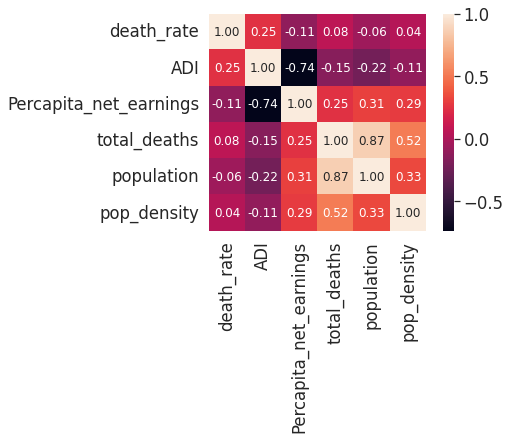

In [ ]:
#Correlation matrix - 

## ADI - Deaths per 1000 
## Deaths per 1000 and percapita net earnings
corr_coef = covid_df[['death_rate','ADI','Percapita_net_earnings','total_deaths','population','pop_density']].corr()

#corr_coef = np.corrcoef(df_Covid.values.T)

sns.set(font_scale=1.5)
heat_map = sns.heatmap(corr_coef,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size':12})
plt.show()

## Data distributions - Boxplots and Histogram visualizations

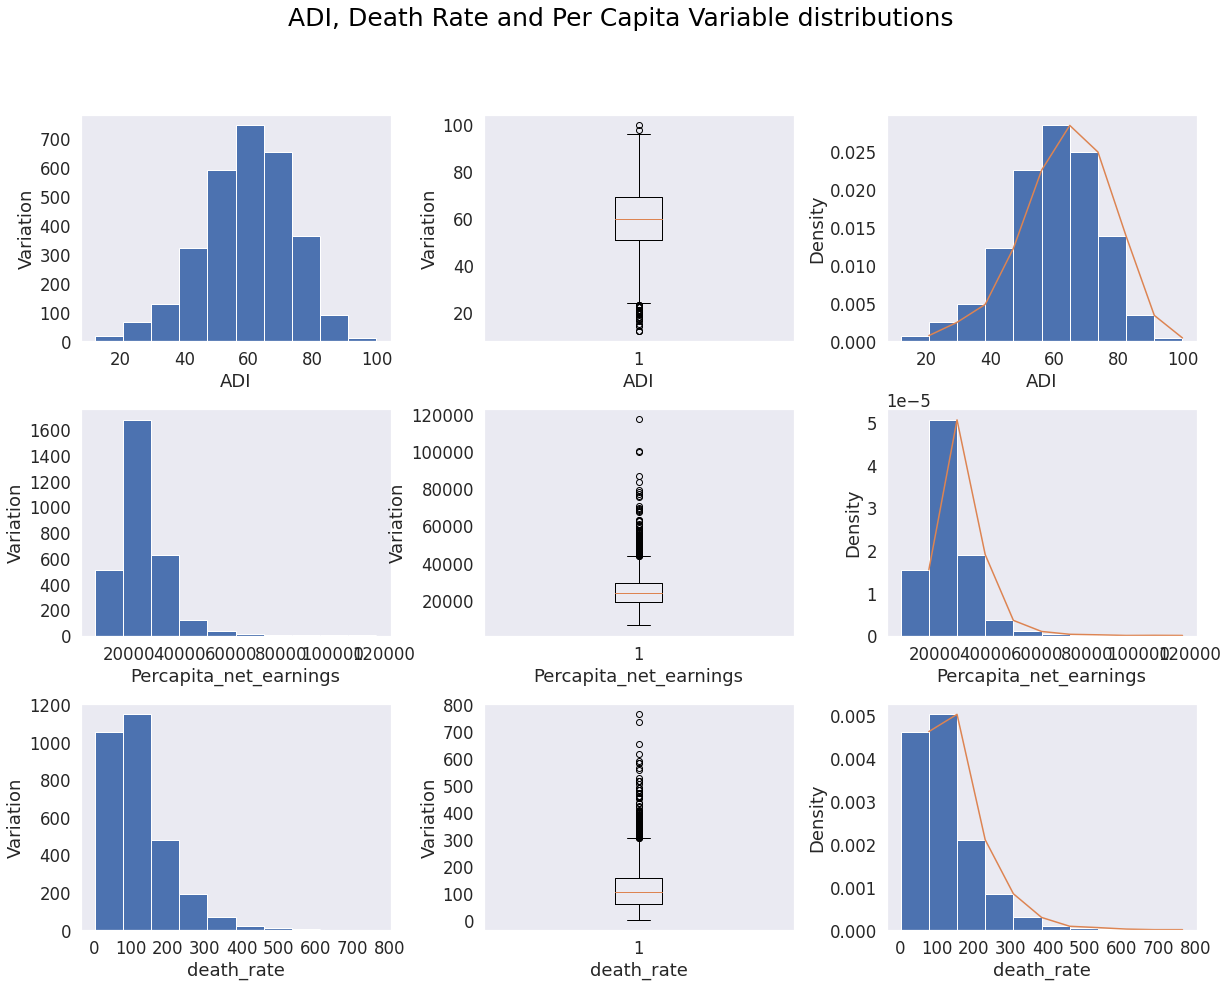

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(20,15))

#Set Style for graph
sns.set_theme()

a = 0

def distribution_subplots(row, df_var):
    # Plotting Histogram
    ax[row,0].hist(covid_df[df_var])
    #ax[row,0].set_title('Histogram', fontsize=15)
    ax[row,0].set_xlabel(df_var)
    ax[row,0].set_ylabel('Variation')
    ax[row,0].grid(False)
    # Plotting Box Plot
    ax[row,1].boxplot(covid_df[df_var])
    #ax[row,1].set_title('Boxplot', fontsize=15)
    ax[row,1].set_xlabel(df_var)
    ax[row,1].set_ylabel('Variation')
    ax[row,1].grid(False)
    # Plotting Density
    a = ax[row,2].hist(covid_df[df_var],density=True)
    ax[row,2].plot(a[1][1:],a[0]) 
    ax[row,2].set_xlabel(df_var)
    ax[row,2].set_ylabel('Density')
    ax[row,2].grid(False)


distribution_subplots(0, 'ADI')
distribution_subplots(1, 'Percapita_net_earnings')
distribution_subplots(2, 'death_rate')

plt.suptitle('ADI, Death Rate and Per Capita Variable distributions',fontsize=25, color="black")
plt.subplots_adjust(wspace=.3, hspace=.3)

# Variable Correlation analysis


### Outlier detection & removal

In [ ]:
### Pulling outliers from Death rate, ADI and percapita net earnings

deaths_percapita_df = covid_df[['death_rate','Percapita_net_earnings']]
deaths_adi_df = covid_df[['death_rate','ADI']]

#For Death rate and either ADI or Per Capita, find rows with a Z score higher than 3 for each col, takes the absolute value of the Z score and then reindex's the DF for the remaining rows which met the previous Z score threshold in both cols for that row

deaths_percapita_cleaned_df = deaths_percapita_df[(np.abs(scstats.zscore(deaths_percapita_df)) < 3).all(axis=1)] 
deaths_adi_cleaned_df = deaths_adi_df[(np.abs(scstats.zscore(deaths_adi_df)) < 3).all(axis=1)]


### Scatterplot Visualizations

In [ ]:
#Death rate to net per capita
x1 = deaths_percapita_df['death_rate']
y1 = deaths_percapita_df['Percapita_net_earnings']
#c1 = deaths_percapita_df['Outliers']

x2 = deaths_percapita_cleaned_df['death_rate']
y2 = deaths_percapita_cleaned_df['Percapita_net_earnings']

### Death rate to ADI
x3 = deaths_adi_df['death_rate']
y3 = deaths_adi_df['ADI']
#c2 = deaths_adi_df['Outliers']

x4 = deaths_adi_cleaned_df['death_rate']
y4 = deaths_adi_cleaned_df['ADI']


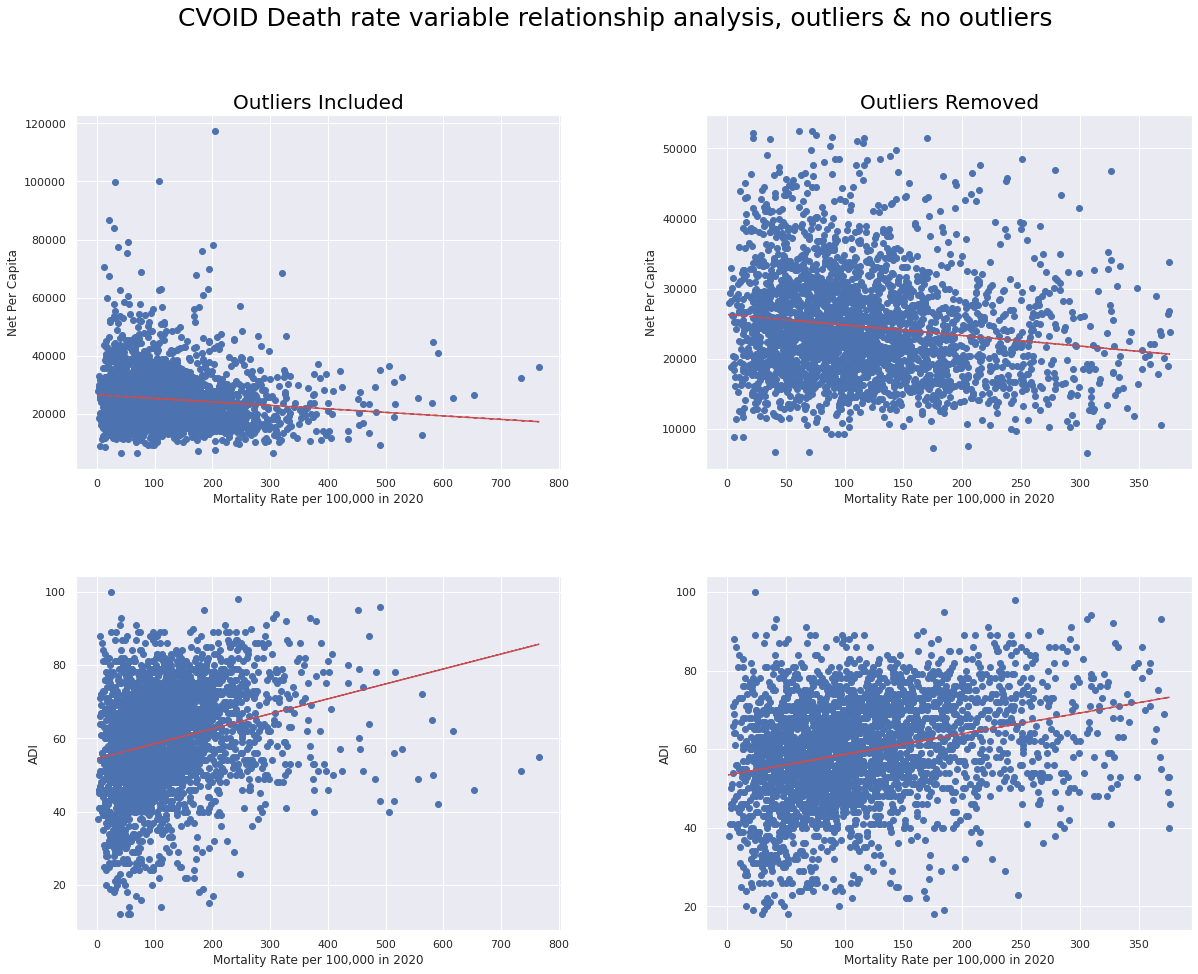

In [ ]:
#Declare plot subplot split 
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(20,15))

#Clean up code by defining repeated statements within functions
def subplot_bestfit(ax1, ax2, x,y):
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax[ax1, ax2].plot(x,p(x),"r--") 


def subplot_scatter(ax1, ax2, x, y, xlabel, ylabel): 
    ax[ax1, ax2].scatter(x, y, cmap='Blues') 
    ax[ax1, ax2].set_xlabel(xlabel)
    ax[ax1, ax2].set_ylabel(ylabel)
    subplot_bestfit(ax1, ax2, x, y)


#Generate Scatterplots
xlabel = 'Mortality Rate per 100,000 in 2020'

subplot_scatter(0,0,x1,y1, xlabel, 'Net Per Capita')
subplot_scatter(0,1,x2,y2, xlabel, 'Net Per Capita')
subplot_scatter(1,0,x3,y3, xlabel, 'ADI')
subplot_scatter(1,1,x4,y4, xlabel, 'ADI')


colors = {True:'tab:red', False:'tab:blue'}

# Generate Column & Plot titles & increase spacing between subplots
ax[0, 0].set_title('Outliers Included', fontsize=20, color='black')
ax[0, 1].set_title('Outliers Removed',fontsize=20, color='black')
plt.suptitle('CVOID Death rate variable relationship analysis, outliers & no outliers',fontsize=25, color="black")
plt.subplots_adjust(wspace=.3, hspace=.3)

#Show plots 
plt.show()

#Simulate Non Parametric Median


Now let's see if we can use bootstrapping to determine if the death rate distribution is diffrent when looking at diffrent ADI brackets



The confidence interval for DS Death Rate is [ 93.38916625 112.47791796] and the mean is 103.1663092803331
The confidence interval for DS Deathrate for ADI 0-30 is [ 34.23325951 124.58801475] and the mean is 69.61533653164943
The confidence interval for DS Deathrate for ADI 30-60 is [ 76.11559893 101.36442111] and the mean is 87.86526487026391
The confidence interval for DS Deathrate for ADI > 60 is [106.10437823 134.88873484] and the mean is 120.88828166263943


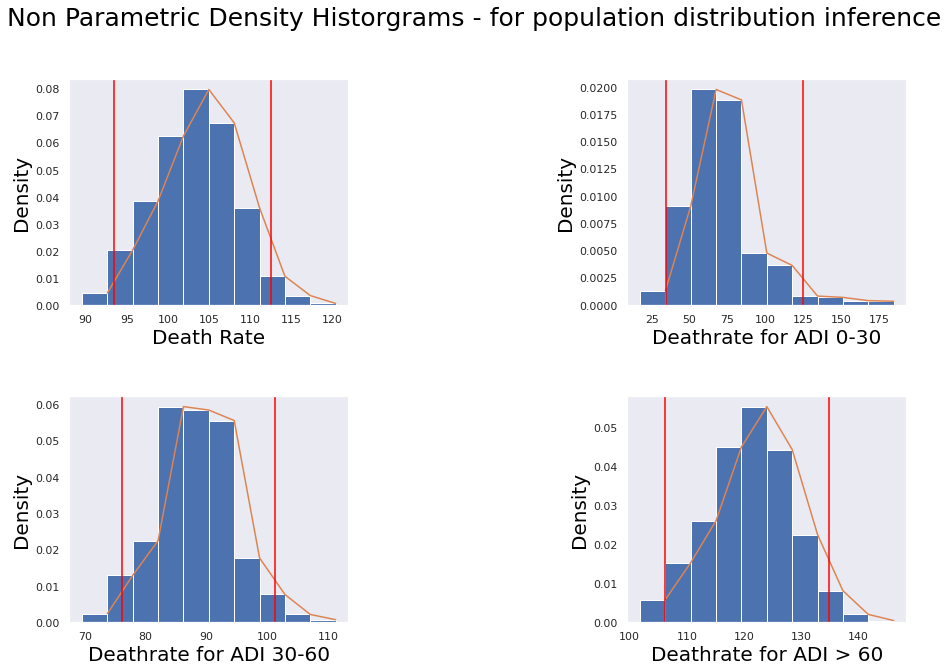

In [56]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
sns.set_theme()

def nonParametric_density_plotter(plt_row, plt_col , df, xlabel, ylabel):
      # Bootstrap w/ first bracket.
      sns.set_theme()
      a = 0
      boot = []
      for i in range(1000):
                boot.append(np.median(df.sample(frac=0.1, replace=True)))

      conf_interval = np.percentile(boot, [2.5, 97.5]) #95th percentile bracket
      print("The confidence interval for DS " + xlabel + " is " +  str(conf_interval) + " and the mean is " + str(np.mean(boot)) )
      sns.set_theme()
      a = ax[plt_row,plt_col].hist(boot,density=True)
      ax[plt_row,plt_col].plot(a[1][1:],a[0]) 
      for endpoint in conf_interval:
          ax[plt_row,plt_col].axvline(endpoint, color='red')
      ax[plt_row,plt_col].set_xlabel(xlabel, fontsize=20, color='black')
      ax[plt_row,plt_col].set_ylabel(ylabel, fontsize=20, color='black')
      ax[plt_row,plt_col].grid(False)


nonParametric_density_plotter(0,0, covid_df['death_rate'], 'Death Rate', 'Density')
nonParametric_density_plotter(0,1, covid_df[covid_df['ADI'] <= 30 ]['death_rate'], 'Deathrate for ADI 0-30', 'Density')
nonParametric_density_plotter(1,0, covid_df[np.logical_and(covid_df['ADI'] < 60, covid_df['ADI'] > 30)]['death_rate'], 'Deathrate for ADI 30-60', 'Density')
nonParametric_density_plotter(1,1, covid_df[covid_df['ADI'] >= 60 ]['death_rate'], 'Deathrate for ADI > 60', 'Density')

plt.suptitle('Non Parametric Density Historgrams - for population distribution inference',fontsize=25, color="black")
plt.subplots_adjust(wspace=1, hspace=.4)
plt.show()